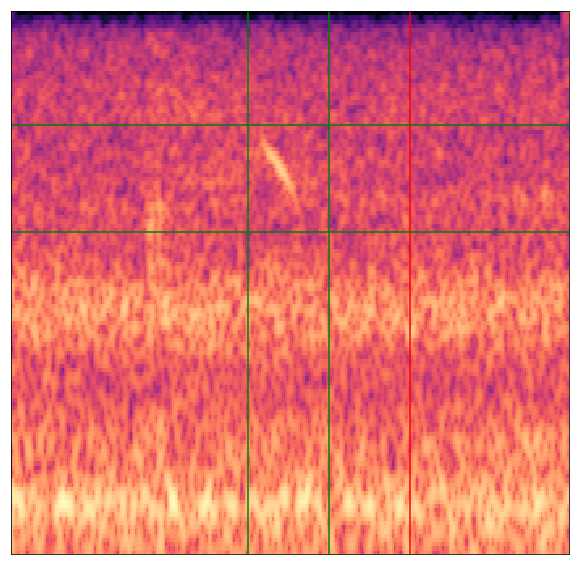

In [1]:
import h5py
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import sys


sys.path.append('../src')
import localmodule

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
tfr_str = 'logmelspec'
if tfr_str == 'logmelspec':
    group_str = 'logmelspec'
elif tfr_str in ['pcen', 'birdpcen']:
    group_str = 'pcen'

pcen_name = "_".join([dataset_name, 'clip-' + group_str])
pcen_dir = os.path.join(data_dir, pcen_name)
original_dir = os.path.join(pcen_dir, 'original')
units = localmodule.get_units()

unit_str = units[0]
unit_name = "_".join([dataset_name, 'original', unit_str]) + ".hdf5"
unit_path = os.path.join(original_dir, unit_name)
unit_file = h5py.File(unit_path, 'r')

keys = list(unit_file[group_str].keys())
positive_keys = [k for k in keys if k.split('_')[3]=='1']

positive_key = positive_keys[30]
freq_hz = int(positive_key.split('_')[2])
pcen = unit_file[group_str][positive_key].value

pcen_settings = localmodule.get_pcen_settings()
mel_scale = librosa.mel_frequencies(
    n_mels=pcen_settings["n_mels"],
    fmin=pcen_settings["fmin"],
    fmax=pcen_settings["fmax"])
center_mel = np.argmin(np.abs(mel_scale - freq_hz))

bottom_mel = center_mel - 15
top_mel = center_mel + 10

center_t = 172
center_t0 = center_t - 25
center_t1 = center_t + 25
center_t2 = center_t + 75

pcen

%matplotlib inline
plt.figure(figsize=(10, 10))
plt.plot([center_t0, center_t0], [0, 128], color='g')
plt.plot([center_t1, center_t1], [0, 128], color='g')
plt.plot([center_t2, center_t2], [0, 128], color='r')
plt.plot([0, 345], [top_mel, top_mel], color='g')
plt.plot([0, 345], [bottom_mel, bottom_mel], color='g')
librosa.display.specshow(pcen)

100%|██████████| 13678/13678 [00:07<00:00, 1714.85it/s]


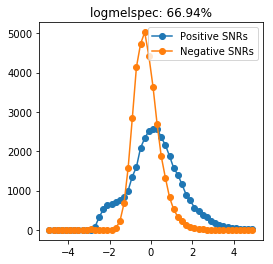

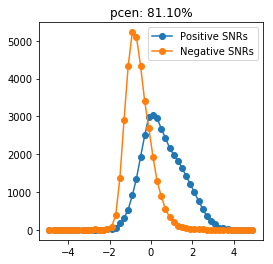

In [12]:
import h5py
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import tqdm


sys.path.append('../src')
import localmodule

pcen_settings = localmodule.get_pcen_settings()
mel_scale = librosa.mel_frequencies(
    n_mels=pcen_settings["n_mels"],
    fmin=pcen_settings["fmin"],
    fmax=pcen_settings["fmax"])

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
tfr_str = 'logmelspec'
if tfr_str == 'logmelspec':
    group_str = 'logmelspec'
elif tfr_str in ['pcen', 'birdpcen']:
    group_str = 'pcen'

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
tfr_strs = ['logmelspec', 'pcen', 'birdpcen']

mel_scale = librosa.mel_frequencies(
    n_mels=pcen_settings["n_mels"],
    fmin=pcen_settings["fmin"],
    fmax=pcen_settings["fmax"])

snr_dicts = []

for tfr_str in tfr_strs[:2]:

    if tfr_str == 'logmelspec':
        group_str = 'logmelspec'
    elif tfr_str in ['pcen', 'birdpcen']:
        group_str = 'pcen'

    tfr_name = "_".join([dataset_name, 'clip-' + tfr_str])
    tfr_dir = os.path.join(data_dir, tfr_name)
    original_dir = os.path.join(tfr_dir, 'original')
    units = localmodule.get_units()

    pcen_settings = localmodule.get_pcen_settings()
    mel_scale = librosa.mel_frequencies(
        n_mels=pcen_settings["n_mels"],
        fmin=pcen_settings["fmin"],
        fmax=pcen_settings["fmax"])

    center_t = 172
    n_frames = 30#104
    center_t0 = center_t - int(n_frames/2)
    center_t1 = center_t + int(n_frames/2)
    n_frames = center_t1 - center_t0
    center_t2 = center_t1 + n_frames
    
    snr_dict = {}


    for unit_str in units:#[units[3]]:

        unit_name = "_".join([dataset_name, 'original', unit_str]) + ".hdf5"
        unit_path = os.path.join(original_dir, unit_name)
        unit_file = h5py.File(unit_path, 'r')

        keys = list(unit_file[group_str].keys())
        positive_snds = []
        negative_snds = []

        for key_id in tqdm.tqdm(range(len(keys))):
            key = keys[key_id]
            freq_hz = int(key.split('_')[2])
            if freq_hz == 0:
                freq_hz = np.random.randint(2000, 10000)
            center_mel = np.argmin(np.abs(mel_scale - freq_hz))
            low_mel = np.maximum(0, center_mel - 25) # 0
            high_mel = low_mel + 50 # 128
            
            tfr = unit_file[group_str][key].value

            event_boundingbox = tfr[low_mel:high_mel, center_t0:center_t1]
            event_argmax = np.argmax(event_boundingbox, axis=1)
            event_maxpool = np.array([event_boundingbox[i, event_argmax[i]]
                for i in range(len(event_argmax))])
            event_bin = np.argmax(event_maxpool)
            signal_level = np.max(event_boundingbox[event_bin, :])
            
            noise_level = np.min(event_boundingbox[event_bin, :])
            snr = signal_level - noise_level
            snr_dict[key] = snr

        unit_file.close()

    snr_dicts.append(snr_dict)

In [1]:
  
%matplotlib inline

for i, snr_dict in enumerate(snr_dicts[:2]):
    positive_dict = {k: snr_dict[k] for k in snr_dict.keys()
                     if k.split('_')[3]=='1'}
    negative_dict = {k: snr_dict[k] for k in snr_dict.keys()
                     if k.split('_')[3]=='0'}
    mean_snr = np.mean(np.array(list(snr_dict.values())))
    std_snr = np.std(np.array(list(snr_dict.values())))

    positive_hist = np.histogram(
        (np.array(list(positive_dict.values())) - mean_snr) / std_snr,
        bins=np.linspace(-5, 5, 51));

    negative_hist = np.histogram(
        (np.array(list(negative_dict.values())) - mean_snr) / std_snr,
        bins=np.linspace(-5, 5, 51));

    positive_bin_centers = 0.5 * (positive_hist[1][1:] + positive_hist[1][:-1])
    negative_bin_centers = 0.5 * (negative_hist[1][1:] + negative_hist[1][:-1])
    
    max_accuracy = np.max(np.cumsum(negative_hist[0]) + np.cumsum(positive_hist[0][::-1])[::-1]) / len(snr_dict)
    
    plt.figure(figsize=(4, 4))
    fig = plt.plot(
        positive_bin_centers, positive_hist[0], '-o',
        negative_bin_centers, negative_hist[0], '-o');
    #plt.ylim(0, 8000)
    plt.title(tfr_strs[i] + ": {:5.2f}%".format(max_accuracy*100))
    plt.gca().legend(['Positive SNRs', 'Negative SNRs'])

NameError: name 'snr_dicts' is not defined